## Use PINN with Rayleigh Loss
PINN solves collocation method with strong-form, with a Rayleigh loss. My goal here is to build two models one $w(x,y) \approx w_{\theta}(x,y)$ and one for second derivatives $ H_{x} w \approx H_{x} w_{\phi}(x,y)$. Then you can get the fourth derivatives by auto-diff on the second-order derivative model.
PINN inspired from this website [PINN]https://georgemilosh.github.io/blog/2022/distill/). 

2024-11-26 17:58:18.101662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 17:58:18.102548: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 17:58:18.105994: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 17:58:18.116062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732661898.131898   20978 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732661898.13

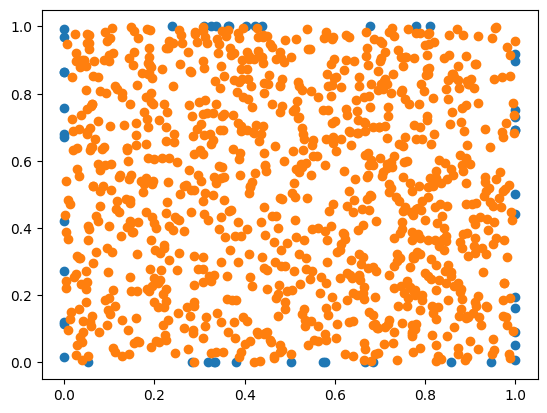

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from src import *
import matplotlib.pyplot as plt

# Set number of data points
N_b = 50
N_r = 10000

# set the boundary of the panel
a = 1
b = 1
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data on y edges
N_bhalf = int(N_b/2)
x_b1 = tf.random.uniform((N_bhalf,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_bhalf,1), 0.5, dtype=DTYPE)

# boundary data on x edges
y_b2 = tf.random.uniform((N_bhalf,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_bhalf,1), 0.5, dtype=DTYPE)

x_b = tf.concat([x_b1, x_b2], axis=0)
y_b = tf.concat([y_b1, y_b2], axis=0)
X_b = tf.concat([x_b, y_b], axis=1)

# set boundary condition values (simply supported)
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
u_b = fun_u_b(x_b, y_b)

# set collocation points in interior
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_b]
u_data = [u_b]

# plot the collocation points on the boundary
plt.scatter(x_b, y_b)
plt.scatter(x_r[:1000], y_r[:1000]) # only show 1000 of the points
plt.show()

In [2]:
import time
tf.compat.v1.enable_eager_execution()

# choose buckling problem inputs
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else: # shear
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# initialize the model
model = PINN_EigenNet(
    lb, ub, num_hidden_layers=2, 
    activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
    kernel_initializer='he_normal'
)
model.model.build(input_shape=(None, 2))
model.build(input_shape=(None, 2))

# Initilize solver
pinn = StrongFormBucklingPINN(D, Nxx, Nxy, Nyy, model, X_r)

print("Eager execution:", tf.executing_eagerly())
model.summary()
# exit(0)

# check something
# print("Trainable variables:", model.trainable_variables)
for var in model.trainable_variables:
    print(f"{type(var)=} {var=}")
    # print(type(var))
# print("Loss:", loss)


# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time.time()
pinn.solve_with_TFoptimizer(optim, X_data, u_data, N=10001)

# Print computation time
print('\nComputation time: {} seconds'.format(time.time()-t0))

Eager execution: True


Model: "pinn__eigen_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501 (3.91 KB)

 Trainable params: 501 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

type(var)=<class 'keras.src.backend.Variable'> var=<Variable path=sequential/dense/kernel, shape=(2, 20), dtype=float64, value=[[-0.92471002  1.56960194  0.01428395  0.22821919 -1.18734682  0.2161587
  -1.92462365 -0.55966518  0.12527769 -0.26703603 -0.82112924 -1.30864492
   0.49508196  0.88607929 -0.33660431  1.13577371  0.57011044 -1.07135694
   1.07868411  0.29420472]
 [ 1.17068437  0.56696054  1.21891002  0.41488254  0.4066454   0.13870921
  -1.80410787  1.3887611   0.69292474  0.0621145  -0.20411254 -1.4045985
   0.53238969 -0.61143651 -1.66481845  0.0083957  -0.45809497 -1.91273672
  -1.29816341  0.32781672]]>
type(var)=<class 'keras.src.backend.Variable'> var=<Variable path=sequential/dense/bias, shape=(20,), dtype=float64, value=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]>
type(var)=<class 'keras.src.backend.Variable'> var=<Variable path=sequential/dense_1/kernel, shape=(20, 20), dtype=float64, value=[[ 0.39983389 -0.03967529 -0.09819904 -0.39901238 -0.018465

ValueError: Passed in object <Variable path=sequential/dense/kernel, shape=(2, 20), dtype=float64, value=[[-0.92471002  1.56960194  0.01428395  0.22821919 -1.18734682  0.2161587
  -1.92462365 -0.55966518  0.12527769 -0.26703603 -0.82112924 -1.30864492
   0.49508196  0.88607929 -0.33660431  1.13577371  0.57011044 -1.07135694
   1.07868411  0.29420472]
 [ 1.17068437  0.56696054  1.21891002  0.41488254  0.4066454   0.13870921
  -1.80410787  1.3887611   0.69292474  0.0621145  -0.20411254 -1.4045985
   0.53238969 -0.61143651 -1.66481845  0.0083957  -0.45809497 -1.91273672
  -1.29816341  0.32781672]]> of type 'Variable', not tf.Tensor or tf.Variable or ExtensionType.